In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from bisect import bisect_right
import functions as f
import winsound

def shift_time(timestamp_str, minutes=0, seconds=0, hours=0):
    # Only time (HH:MM:SS)
    if len(timestamp_str) == 8:
        h = int(timestamp_str[0:2])
        m = int(timestamp_str[3:5])
        s = int(timestamp_str[6:8])
        total = h * 3600 + m * 60 + s + hours * 3600 + minutes * 60 + seconds
        total %= 86400  # Wrap around 24h
        return f"{total // 3600:02}:{(total % 3600) // 60:02}:{total % 60:02}"

    # Only date (YYYY-MM-DD)
    elif len(timestamp_str) == 10:
        y, mo, d = map(int, timestamp_str.split("-"))
        t = timedelta(hours=hours, minutes=minutes, seconds=seconds)
        dt = datetime(y, mo, d) + t
        return dt.strftime("%Y-%m-%d")

    # Full datetime (YYYY-MM-DD HH:MM:SS)
    else:
        y = int(timestamp_str[0:4])
        mo = int(timestamp_str[5:7])
        d = int(timestamp_str[8:10])
        h = int(timestamp_str[11:13])
        m = int(timestamp_str[14:16])
        s = int(timestamp_str[17:19])
        total = (datetime(y, mo, d, h, m, s) +
                 timedelta(hours=hours, minutes=minutes, seconds=seconds))
        return total.strftime("%Y-%m-%d %H:%M:%S")

def calculate_candle_gains(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()  # Avoid modifying the original DataFrame
    df['STD_gain'] = round(df['STD'].pct_change() * 100, 2)
    df['Middle_gain'] = round(df['Middle'].pct_change() * 100, 2)

    return df

TIME_RANGE_SORTED_1T = pd.date_range(start='09:15:00', end='15:30:00', freq='5s').strftime('%H:%M:%S').tolist()

def get_resume_index(df, while_time):
    idx = np.searchsorted(TIME_RANGE_SORTED_1T, while_time, side='right') - 1

    # Early exit if while_time is beyond last possible time
    if idx >= len(TIME_RANGE_SORTED_1T):
        return None

    rounded_arr = df['time'].values

    # Loop until a matching time is found in df
    while idx < len(TIME_RANGE_SORTED_1T):
        next_time = TIME_RANGE_SORTED_1T[idx]
        match_idx = np.flatnonzero(rounded_arr == next_time)

        if match_idx.size > 0:
            return match_idx[0] - len(df)

        idx += 1

    return None  # No future matching time found

results_ddff = []

# === Paths ===
sym_df_folder_path = r'D:\Offline Data\Processed Data\Get_symbol'
sym_df_folder_path = f.convert_csv_to_parquet(sym_df_folder_path)

folder_path = r'D:\Offline Data\Processed Data\Nifty_5_Second_ICICI\Nifty_5_Second_with_indicator_ICICI'
folder_path = f.convert_csv_to_parquet(folder_path)

su_1m_folder_path = r'D:\Offline Data\Processed Data\Nifty_1_Minute_ICICI\Nifty_1_Minute_with_indicator_ICICI'
su_1m_folder_path = f.convert_csv_to_parquet(su_1m_folder_path)

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]

# === Loop through files ===
for n in range(0, len(csv_files)):

    # print(f"Processing File: {csv_files[n]}")

    current_date = csv_files[n].replace('.parquet', '').replace('_', '-')
    print(f"Current Date: ===== {current_date} =====")

    # ===== 5 Second df Main =====
    file_path = os.path.join(folder_path, csv_files[n])
    _5s_df = pd.read_parquet(file_path)
    _5s_df = calculate_candle_gains(_5s_df)
    _5s_df['time'] = _5s_df['datetime'].str[-8:]
    _5s_symbol_groups = {k: v.reset_index(drop=True) for k, v in _5s_df.groupby('symbol')}    # Precompute Lookup

    # ===== 1 Minute supporting df =====
    su_1m_file_path = os.path.join(su_1m_folder_path, csv_files[n])
    _su_1m_df = pd.read_parquet(su_1m_file_path)
    su_1m_symbol_groups = {k: v.reset_index(drop=True) for k, v in _su_1m_df.groupby('symbol')}    # Precompute Lookup

    # ===== Find symbol =====
    sym_file_path = os.path.join(sym_df_folder_path, csv_files[n])
    sym_df = pd.read_parquet(sym_file_path)
    time_to_symbol = dict(zip(sym_df['time'], sym_df['symbol']))    # Precompute Lookup

    # -----------------------------

    while_time = "09:15:00"

    entry_price = None                  # Backtesting 
    entry_index = None                  # Backtesting

    symbol_change_Flag = False   
    symbol_change_Flag_symbol = None

    while True:
        current_symbol = symbol_change_Flag_symbol if symbol_change_Flag else time_to_symbol.get(while_time)
        # print(current_symbol, symbol_change_Flag_symbol, symbol_change_Flag, time_to_symbol.get(while_time), while_time)
        symbol_change_Flag = False   

        df = _5s_symbol_groups.get(current_symbol)
        length_df = -len(df)
        # print(length_df)

        su_1m_df = su_1m_symbol_groups.get(current_symbol)
        su_1m_dict = dict(zip(su_1m_df['datetime'].values, su_1m_df.to_dict('records')))
        keys = list(su_1m_dict.keys())
        length_su_1m_df = len(su_1m_df)

        datetime_arr = df['datetime'].values
        symbol_arr = df['symbol'].values
        open_arr = df['open'].values
        high_arr = df['high'].values
        low_arr = df['low'].values
        close_arr = df['close'].values
        open_interest_arr = df['open_interest'].values
        volume_arr = df['volume'].values
        STD_arr = df['STD'].values
        Middle_arr = df['Middle'].values
        Upper_arr = df['Upper'].values
        Lower_arr = df['Lower'].values
        pctB_arr = df['%B'].values
        STD_gain_arr = df['STD_gain'].values
        Middle_gain_arr = df['Middle_gain'].values
        time_arr = df['time'].values

        resume_index = get_resume_index(df, while_time) if while_time != "09:15:00" else -len(df)

        entry_signal_is = False
        # print("a", while_time, "--------------------------------------")

        for i in range(resume_index, 0):
            # print("i am hear 001")
            # print(datetime_arr[i])
            while_time = datetime_arr[i][-8:] 

            if symbol_change_Flag and not entry_signal_is:
                break

            next_symbol = time_to_symbol.get(shift_time(while_time, minutes=-1))

            if next_symbol != symbol_arr[i] and next_symbol is not None:
                if not entry_signal_is:
                    # print("Symbol Change", symbol_arr[i], next_symbol)
                    symbol_change_Flag_symbol = next_symbol
                    symbol_change_Flag = True
                    break
                else:
                    symbol_change_Flag_symbol = next_symbol
                    symbol_change_Flag = True

            target_time = datetime_arr[i][:-2] + '00'

            if target_time[-8:] > "09:17:00":
                idx_1m = keys.index(target_time) - length_su_1m_df

                prev_row_1 = su_1m_dict[keys[idx_1m - 1]]
                prev_row_2 = su_1m_dict[keys[idx_1m - 2]]
                prev_row_3 = su_1m_dict[keys[idx_1m - 3]]
                # print(datetime_arr[i])

                # ==========================================
                # ==========================================
                # Backtesting

                if not entry_signal_is:
            
                    STD_cond = STD_arr[i] - 0.5 <= 12.0 <= STD_arr[i] + 0.5
                    pctB = pctB_arr[i] - 0.05 <= 0.18 <= pctB_arr[i] + 0.05
                    # opti_ve = 5 > STD_gain_arr[i-1] > -5

                    entry_signal_is = STD_cond and pctB #and opti_ve

                    if entry_signal_is:
                        print("---- Entry ----", symbol_arr[i][-7:])
                        print(datetime_arr[i])

                        entry_price = close_arr[i]
                        entry_time = datetime_arr[i]
                        entry_index = i

                        next_symbol = time_to_symbol.get(shift_time(while_time, minutes=-1))

                        if next_symbol != symbol_arr[i] and next_symbol is not None:
                            winsound.PlaySound("alarm.wav", winsound.SND_FILENAME | winsound.SND_ASYNC)
                            print("\033[1;31mSymbol error\033[0m")
                            raise Exception("\033[1;31mSymbol error\033[0m")

                else:
                    exit_price = None
                    exit_time = None
                    exit_index = None
                    exit_message = None

                    sl_1 = entry_price * 0.98 
                    tp_1 = entry_price * 1.50

                    # sl_1
                    if (low_arr[i] < sl_1 or i == -1) and entry_signal_is:
                        print("---- sl_1 ----")
                        print(datetime_arr[i])
                        exit_price = (close_arr[i] if i == -1 else sl_1) * 0.9975  # Charging 0.25% brokerage
                        exit_time = datetime_arr[i]
                        exit_message = 'sl_1'
                        exit_index = i
                        entry_signal_is = False

                    # tp_1
                    if (high_arr[i] > tp_1 or i == -1) and entry_signal_is:
                        print("---- tp_1 ----")
                        print(datetime_arr[i])
                        exit_price = (close_arr[i] if i == -1 else tp_1) * 0.9975  # Charging 0.25% brokerage
                        exit_time = datetime_arr[i]
                        exit_message = 'tp_1'
                        exit_index = i
                        entry_signal_is = False

                    if not entry_signal_is:
                        # print("i am hear 002")

                        pnl = round(((exit_price - entry_price) / entry_price) * 100, 2)
                        candle_in_trade_CE = abs(entry_index - exit_index)

                        results_ddff.append({
                            'Strike': symbol_arr[entry_index],
                            'Entry_price': entry_price,
                            'Exit_price': exit_price,
                            'Exit_message': exit_message,
                            'Entry_time': entry_time,
                            'Exit_time': exit_time,
                            'pnl': pnl,
                            'candle_in_trade': candle_in_trade_CE,

                            'data_for_filtering_losing_trade_STD_gain_arr': STD_gain_arr[entry_index-1],
                            'data_for_filtering_losing_trade_Middle_gain_arr': Middle_gain_arr[entry_index-1],
                            'data_for_filtering_losing_trade_prev_row_1m': prev_row_1['close'] > prev_row_1['open'],
                            'data_for_filtering_losing_trade_prev_row_1m_gain': round(((prev_row_1['close'] - prev_row_1['open']) / prev_row_1['open']) * 100, 2),

                            'Upper_arr': Upper_arr[entry_index],
                            'Middle_arr': Middle_arr[entry_index],
                            'Lower_arr': Lower_arr[entry_index],
                            'STD_arr': STD_arr[entry_index],
                            'pctB_arr': pctB_arr[entry_index],
                            'STD_gain_arr': STD_gain_arr[entry_index],
                            'Middle_gain_arr': Middle_gain_arr[entry_index],
                        })

                        # ---------- Plotting -----------

                        # if pnl > 0:
                        if False:

                            # main 5 second
                            starting, ending = f.starting_ending(entry_index, exit_index, length_df)
                            df_for_plot = df[starting:].copy() if ending == -1 else df[starting:ending].copy()

                            f.plot_chart(df_for_plot,
                                        entry_time = entry_time, exit_time = exit_time,
                                        entry_price = entry_price, exit_price = exit_price,
                                        position = "Long",
                                        pnl = pnl,
                                        trade_n = 0,
                                        supertrend_start_time = entry_time,
                                        plot_bollinger = True,
                                        plot_pctb = True,
                                        plot_supertrend = False,
                                        plot_entry_exit = True,
                                        save_chart = False)
                            
                            # 1 minute
                            entry_time_1m = entry_time[-8:-2] + '00'
                            exit_time_1m = exit_time[-8:-2] + '00'

                            entry_index_1m = keys.index(entry_time[:-2] + '00') - length_su_1m_df
                            exit_index_1m = keys.index(exit_time[:-2] + '00') - length_su_1m_df

                            starting_1m, ending_1m = f.starting_ending(entry_index_1m, exit_index_1m, -length_su_1m_df)
                            df_for_plot_1m = su_1m_df[starting_1m:].copy() if ending_1m == -1 else su_1m_df[starting_1m:ending_1m].copy()

                            f.plot_chart(df_for_plot_1m,
                                        entry_time = entry_time_1m, exit_time = exit_time_1m,
                                        entry_price = entry_price, exit_price = exit_price,
                                        position = "Long",
                                        pnl = pnl,
                                        trade_n = 0,
                                        supertrend_start_time = entry_time_1m,
                                        plot_bollinger = True,
                                        plot_pctb = True,
                                        plot_supertrend = False,
                                        plot_entry_exit = True,
                                        save_chart = False)

                # ==========================================
                # ==========================================

        if i == -1:
            break

ddff = pd.DataFrame(results_ddff)


All files already converted to parquet format
All files already converted to parquet format
All files already converted to parquet format
Current Date: ===== 2025-01-01 =====
Current Date: ===== 2025-01-02 =====
---- Entry ---- 23650CE
2025-01-02 10:14:25
---- tp_1 ----
2025-01-02 12:25:20
Current Date: ===== 2025-01-03 =====
Current Date: ===== 2025-01-06 =====
Current Date: ===== 2025-01-07 =====
Current Date: ===== 2025-01-08 =====
---- Entry ---- 23450CE
2025-01-08 10:21:25
---- sl_1 ----
2025-01-08 10:21:30
Current Date: ===== 2025-01-09 =====
Current Date: ===== 2025-01-10 =====
Current Date: ===== 2025-01-13 =====
---- Entry ---- 23200CE
2025-01-13 10:42:45
---- sl_1 ----
2025-01-13 11:03:40
Current Date: ===== 2025-01-14 =====
Current Date: ===== 2025-01-15 =====
Current Date: ===== 2025-01-16 =====
Current Date: ===== 2025-01-17 =====
---- Entry ---- 23100CE
2025-01-17 10:50:10
---- sl_1 ----
2025-01-17 10:50:40
---- Entry ---- 23100CE
2025-01-17 10:50:45
---- sl_1 ----
2025-0

Profit       : 299.28 %
Total Trades : 44
Avg Gain per trade   : 6.8 %
Avg Bar per trade    : 330.0
Percent Profitable   : 25.0 %
Profit Factor        : 0.32
Max Drawdown : -13.46
✅ Saved plot to: Result_charts\Backtesting_statestic.png


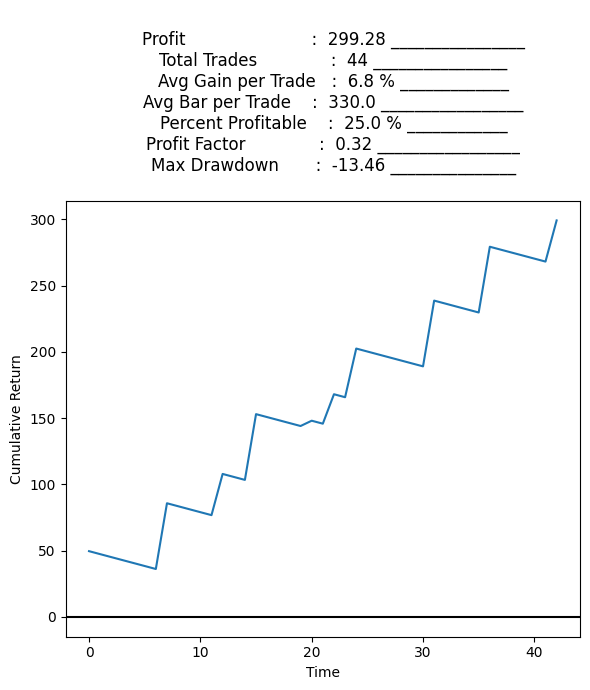

In [2]:
def plot_results(ddff):

    total_profit = round(ddff['pnl'].sum(), 2)
    print("Profit       :", total_profit, "%")

    total_trades = len(ddff) + 1
    print("Total Trades :", total_trades)

    avg_gain_per_trade = round(total_profit / total_trades, 2)
    print("Avg Gain per trade   :", avg_gain_per_trade, "%")

    avg_bar_per_trade = ddff['candle_in_trade'].sum() / total_trades
    print("Avg Bar per trade    :", round(avg_bar_per_trade, 0))

    winning_trades = len(ddff[ddff['pnl'] > 0]) + 1
    percent_profitable = ((winning_trades - total_trades)/total_trades) * 100 + 100
    print("Percent Profitable   :", round(percent_profitable, 2), "%")

    lossing_trades = len(ddff[ddff['pnl'] < 0]) + 1
    profit_factor = winning_trades/lossing_trades
    print("Profit Factor        :", round(profit_factor, 2))

    def calculate_max_drawdown(ddff):
        df = ddff.copy()
        df['Cumulative_return'] = df['pnl'].cumsum()
        df['Max Peak'] = df['Cumulative_return'].cummax()
        df['Drawdown'] = df['Cumulative_return'] - df['Max Peak']
        max_drawdown = df['Drawdown'].min()
        return round(max_drawdown, 2)

    max_drawdown = calculate_max_drawdown(ddff)
    print("Max Drawdown :", max_drawdown)

    output_string = f"""
    Profit                        :  {total_profit} ________________
    Total Trades              :  {total_trades} ________________
    Avg Gain per Trade   :  {avg_gain_per_trade} % _____________
    Avg Bar per Trade    :  {round(avg_bar_per_trade, 0)} _________________
    Percent Profitable    :  {round(percent_profitable, 2)} % ____________
    Profit Factor              :  {round(profit_factor, 2)} _________________
    Max Drawdown       :  {max_drawdown} _______________
    """

    save_file_name = f"Backtesting_statestic" #f"{target_pct}_and_{sl_pct}"

    f.plot_cumulative_return(ddff, output_string, save_file_name, save_fig=True)

plot_results(ddff)